# Adevinta: Clustering and Profiling

Hierarchical clustering is a super useful way of segmenting observations. The advantage of not having to pre-define the number of clusters gives it quite an edge over k-Means.

In [109]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [110]:
%matplotlib inline

In [111]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Adevinta: Dataset loading and description

In [160]:
df_fotocasa = pd.read_pickle("./data/df_fotocasa_sell.pkl")

In [161]:
df_fotocasa.head()

,idproperty,province,municipality,surface,rooms,baths,property_subtype,price,latitude,longitude
0,qkgdhixsul,Girona,Castell-Platja d'Aro,60,2,1,Apartamento,178000.0,41.818661,3.044996
1,swigwvclxz,Barcelona,Vilanova i la Geltrú,197,4,2,Casa-Chalet,345000.0,41.224199,1.725633
2,bfvgsrcdoj,Lleida,Fondarella,375,5,3,Casa-Chalet,180000.0,41.634281,0.873969
3,tsracvmevc,Girona,Girona Capital,89,4,2,Piso,187000.0,41.979301,2.819944
4,biayppbmen,Barcelona,Manresa,180,6,1,Piso,350000.0,41.728894,1.828677


In [162]:
print("\nObservations: {}, Features: {}\n".format(
    df_fotocasa.shape[0], df_fotocasa.shape[1]-1))


Observations: 923, Features: 9



In [163]:
df_fotocasa = df_fotocasa[df_fotocasa.price > 0.0].copy()
df_fotocasa = df_fotocasa[df_fotocasa.surface > 0.0].copy()
df_fotocasa = df_fotocasa[df_fotocasa.rooms > 0.0].copy()
df_fotocasa = df_fotocasa[df_fotocasa.baths > 0.0].copy()

df_fotocasa['price_x_m2'] = \
    df_fotocasa.price / df_fotocasa.surface

In [164]:
n_counts = df_fotocasa.shape[0]

In [167]:
rooms_freq = df_fotocasa.rooms.value_counts().to_dict()
baths_freq = df_fotocasa.baths.value_counts().to_dict()
province_freq = df_fotocasa.province.value_counts().to_dict()
municipality_freq = df_fotocasa.municipality.value_counts().to_dict()
property_subtype_freq = df_fotocasa.property_subtype.value_counts().to_dict()
#transacion_type_freq = df_fotocasa.transacion_type.value_counts().to_dict()

df_fotocasa['rooms_freq'] = \
    df_fotocasa.rooms.apply(lambda x : rooms_freq[x]/n_counts)
df_fotocasa['baths_freq'] = \
    df_fotocasa.baths.apply(lambda x : baths_freq[x]/n_counts)
df_fotocasa['province_freq'] = \
    df_fotocasa.province.apply(lambda x : province_freq[x]/n_counts)
df_fotocasa['municipality_freq'] = \
    df_fotocasa.municipality.apply(lambda x : municipality_freq[x]/n_counts)
df_fotocasa['property_subtype_freq'] = \
    df_fotocasa.property_subtype.apply(lambda x : property_subtype_freq[x]/n_counts)
#df_fotocasa['transacion_type_freq'] = \
#    df_fotocasa.transacion_type.apply(lambda x : transacion_type_freq[x]/n_counts)

In [168]:
df_fotocasa.shape

(889, 16)

### Adevinta: Dataset missing values and duplicates

In [208]:
df_fotocasa_vars = df_fotocasa[
    ["idproperty",
     #"longitude",
     #"latitude",
     "baths",
     #"baths_freq",
     "rooms",
     #"rooms_freq",
     "surface",
     #"price",
     #"province_freq",
     #"municipality_freq",
     #"property_subtype_freq",
     #"transacion_type_freq",
     #"price_x_m2"
]].copy()

df_fotocasa_new = pd.concat([
    df_fotocasa_vars, 
    #pd.get_dummies(df_fotocasa.province),
    #pd.get_dummies(df_fotocasa.municipality),    
    pd.get_dummies(df_fotocasa.property_subtype),
    #pd.get_dummies(df_fotocasa.transacion_type)
], axis=1,sort=False)

#df_fotocasa_raw = df_fotocasa_new.copy()
df_fotocasa_raw = \
    df_fotocasa_new.groupby(['idproperty']).first().reset_index()

df_fotocasa_raw.shape

(846, 14)

# Adevinta: Hierarchical Clustering

Normalize the features dataframe

In [209]:
from sklearn.preprocessing import normalize

data = df_fotocasa_raw[list(df_fotocasa_raw.columns[1:])]

data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

Plot the dendogram for the Hierarchical Clustering

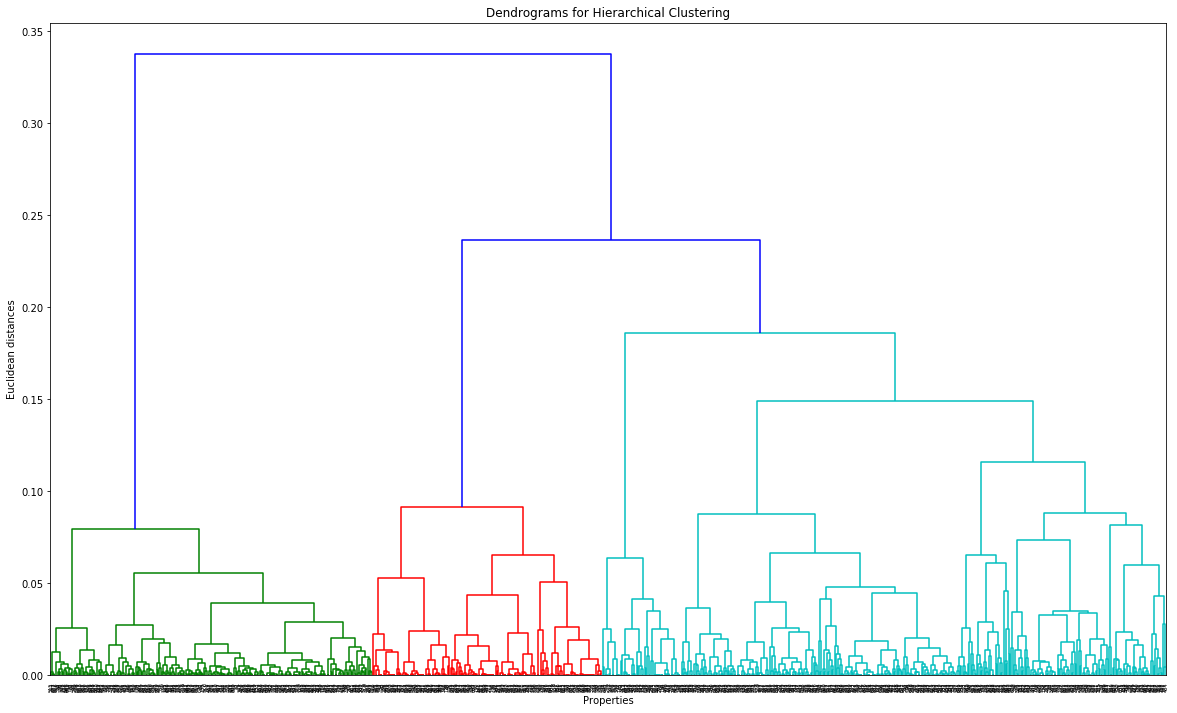

In [211]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20,12))  
plt.title("Dendrograms for Hierarchical Clustering")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.xlabel('Properties')
plt.ylabel('Euclidean distances')
plt.axhline(y=2.5, color='grey', linestyle='--')
plt.axhline(y=1.0, color='grey', linestyle='--')
plt.axhline(y=.5, color='grey', linestyle='--')

Check for the required number of clusters

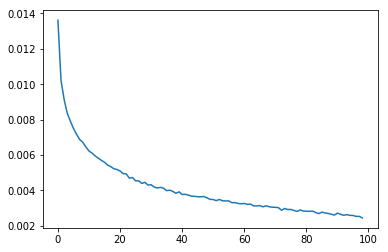

In [212]:
from scipy import cluster
cluster_array = [cluster.vq.kmeans(data_scaled, i) for i in range(1,100)]

ax = plt.plot([var for (cent,var) in cluster_array])
plt.show()

**Model fitting:** Agglomerative Clustering

In [213]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster_labels = cluster.fit_predict(data_scaled)

In [215]:
from joblib import dump, load
dump(cluster, './models/cluster_agglomerative.joblib') 

['./models/cluster_agglomerative.joblib']

**Profiling**

In [214]:
df_fotocasa_raw['label'] = cluster_labels

In [233]:
df_fotocasa_raw[df_fotocasa_raw.label == 5]

,idproperty,baths,rooms,surface,Apartamento,Casa adosada,Casa-Chalet,Dúplex,Estudio,Finca rústica,Loft,Piso,Planta baja,Ático,label
18,alescpxvfc,2,3,86,0,1,0,0,0,0,0,0,0,0,5
35,aytglnpdgj,2,5,140,0,0,1,0,0,0,0,0,0,0,5
46,bfzoucqvmy,2,3,70,0,1,0,0,0,0,0,0,0,0,5
102,dbtkrqizqj,3,7,175,0,0,1,0,0,0,0,0,0,0,5
108,dgtqxjuzkr,1,3,85,0,0,1,0,0,0,0,0,0,0,5
146,ejtdztnmst,3,4,68,0,0,1,0,0,0,0,0,0,0,5
155,eurxagttck,1,5,120,0,0,1,0,0,0,0,0,0,0,5
168,figvxeurcr,1,3,80,0,0,1,0,0,0,0,0,0,0,5
210,gouzhzhssz,2,5,115,0,0,0,0,0,1,0,0,0,0,5
225,hdkezdifht,1,3,72,0,0,1,0,0,0,0,0,0,0,5


In [33]:
df_fotocasa_raw[df_fotocasa_raw.label == 1].describe()

,province_freq,municipality_freq,property_subtype_freq,price_x_m2,label
count,296.000000,296.000000,296.00000,296.000000,296.0
mean,235.733108,6.597973,146.37500,2627.512391,1.0
std,73.180388,5.680522,92.27614,1242.368589,0.0
min,128.000000,1.000000,3.00000,716.666667,1.0
25%,170.000000,2.000000,64.00000,1899.880383,1.0
50%,275.000000,5.000000,156.00000,2414.518900,1.0
75%,316.000000,7.250000,224.00000,3063.629032,1.0
max,316.000000,22.000000,301.00000,10833.333333,1.0


In [35]:
#plt.figure(figsize=(10, 7))  
#plt.scatter(
#    df_fotocasa_raw['price_x_m2'], 
#    df_fotocasa_raw['baths'], 
#    c=cluster.labels_) 

# Adevinta: K-means Clustering

**Dimensionality reduction:** PCA

/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


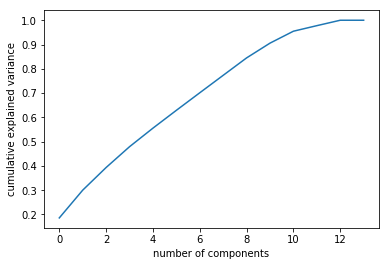

In [224]:
df_features = df_fotocasa_raw.copy()

data = np.array(df_features[df_features.columns[1:]])
scaler = StandardScaler()
scaler.fit(data)
X = scaler.transform(data)

from sklearn.decomposition import PCA

X_pca = PCA().fit(X)
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [225]:
X_pca.explained_variance_ratio_.cumsum()*100

array([ 18.57574348,  30.00835109,  39.33955243,  47.90931406,
        55.55317036,  62.89316668,  70.12329796,  77.31268637,
        84.48966821,  90.57262402,  95.48313142,  97.76863921,
       100.        , 100.        ])

In [226]:
pca = PCA(n_components=12)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (846, 14)
transformed shape: (846, 12)


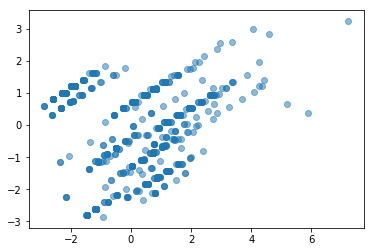

In [227]:
plt.scatter(X_pca[:, 0], 
            X_pca[:, 1], 
            alpha=.5)

**Silouethe analysis**

In [197]:
import numpy as np
import datetime
import pandas as pd
import requests

import warnings

#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
#from sklearn.preprocessing import scale
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from mpl_toolkits.mplot3d import Axes3D


def siloutte_analisys(n_size,n_clusters,X_r2,df_features,min_samples=5,algo='DBSCAN',n_step=10):
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,25))
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.5, 0.8])
    
    clusterer = None
    if (algo=='DBSCAN'):
        clusterer = DBSCAN(min_samples=min_samples)
    elif (algo=='KMEANS'):
        clusterer = KMeans(n_clusters=n_clusters,random_state=8)
    elif (algo=='AFFINITY'):
        clusterer = AffinityPropagation(preference=-50)
    elif (algo=='MINI'):
        clusterer = MiniBatchKMeans(n_clusters=n_clusters)
    else:
        pass

    cluster_labels = None    
    if (algo=='MINI'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            fa_ = clusterer.fit(X_r2)
            cluster_labels = fa_.predict(X_r2)
    else:
        cluster_labels = clusterer.fit_predict(X_r2)


    df_x = df_features.copy()
    #df_x['label'] = cluster_labels
    df_x['label'] = clusterer.labels_ 

    silhouette_avg = silhouette_score(X_r2, cluster_labels,sample_size=1000)
    sample_silhouette_values = silhouette_samples(X_r2[0:n_size], cluster_labels[0:n_size])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels[0:n_size] == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + n_step  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_r2[:, 0], X_r2[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors)

    if ((algo=='KMEANS') or (algo=='AFFINITY')):
        centers = clusterer.cluster_centers_
     
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Method: "+algo+" - Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

    return df_x, cluster_labels, plt, silhouette_avg

0.29360894243160107
0.32160944323772855
0.41264756188262935
0.4817425907755208
0.5209003742297057
0.5863048949575854
0.6020201008830596
0.6168906056741386
0.631476785778261
0.6371728187081395
0.5870877752780743
0.5923234988437653
0.5558341408388824
0.5572605069361591
0.5714349235647262
0.47218695351936657
0.4666101578643428
0.4808935689809111


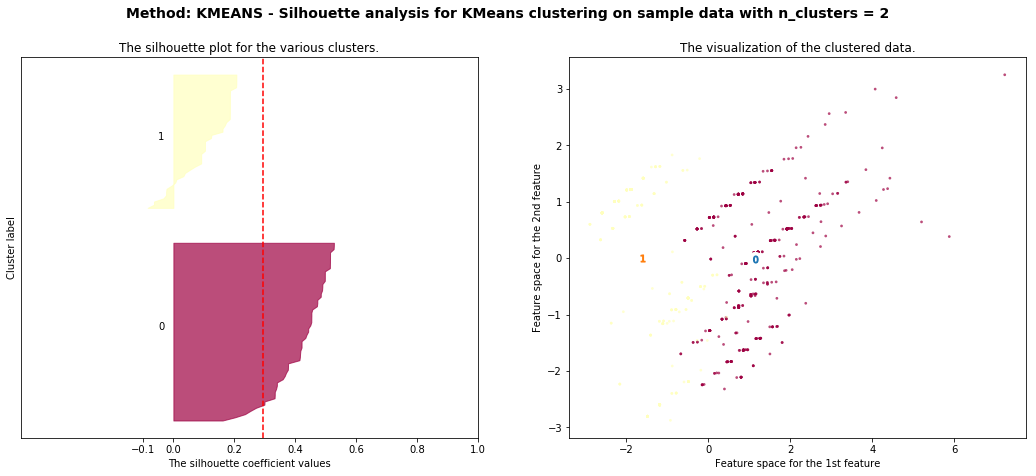

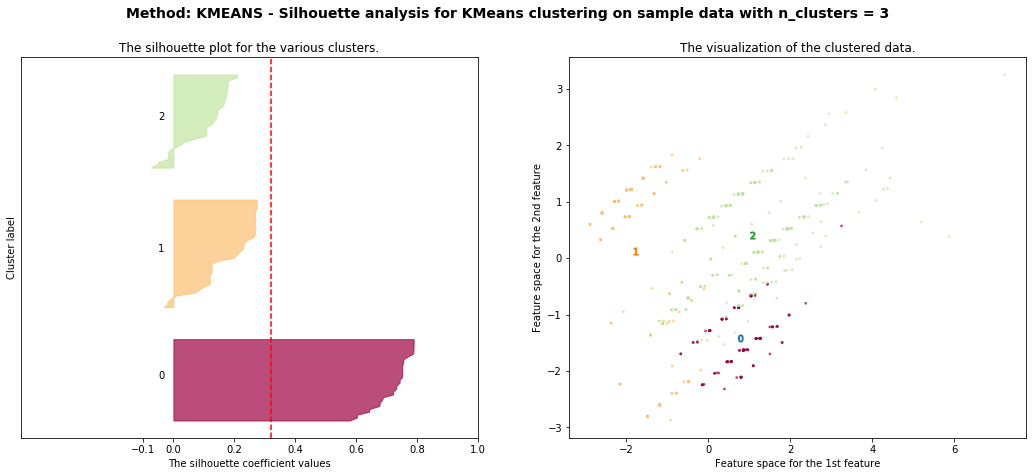

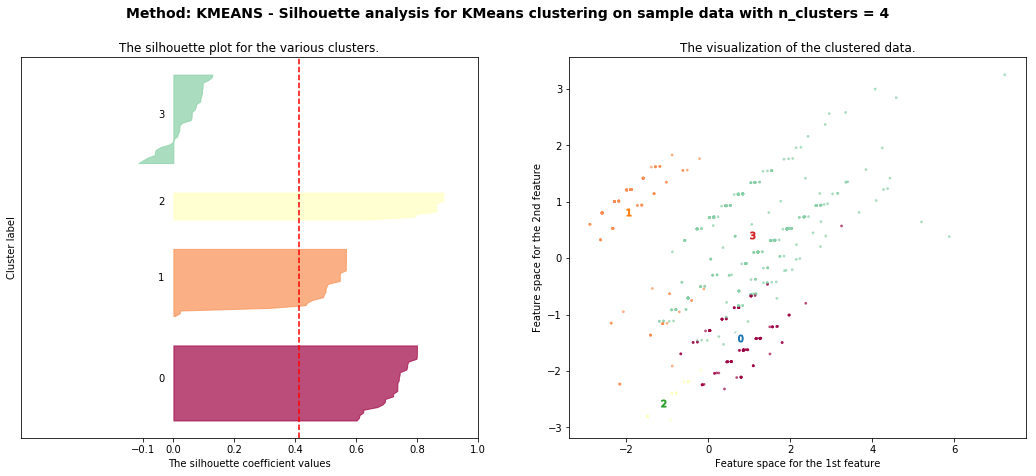

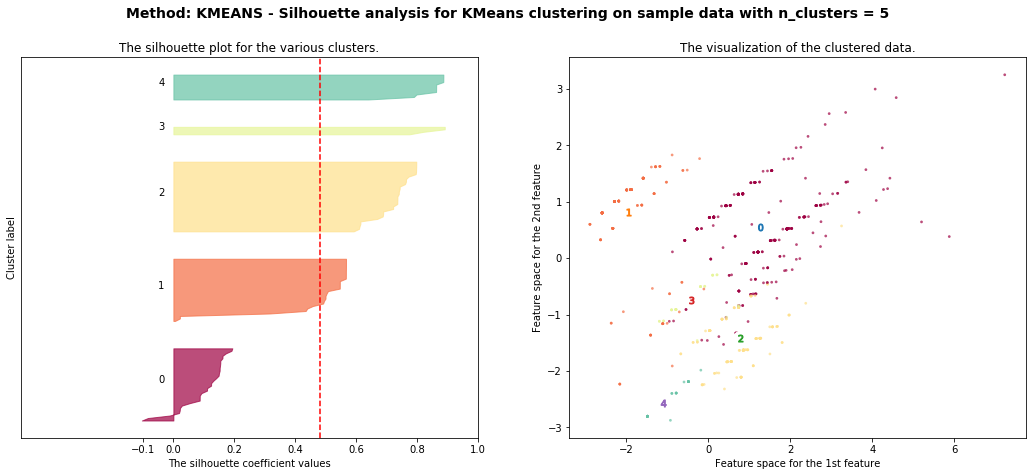

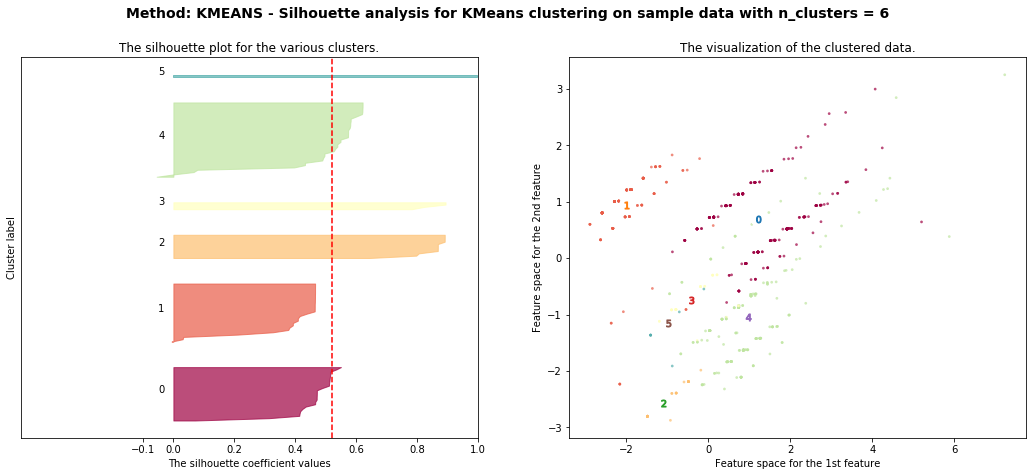

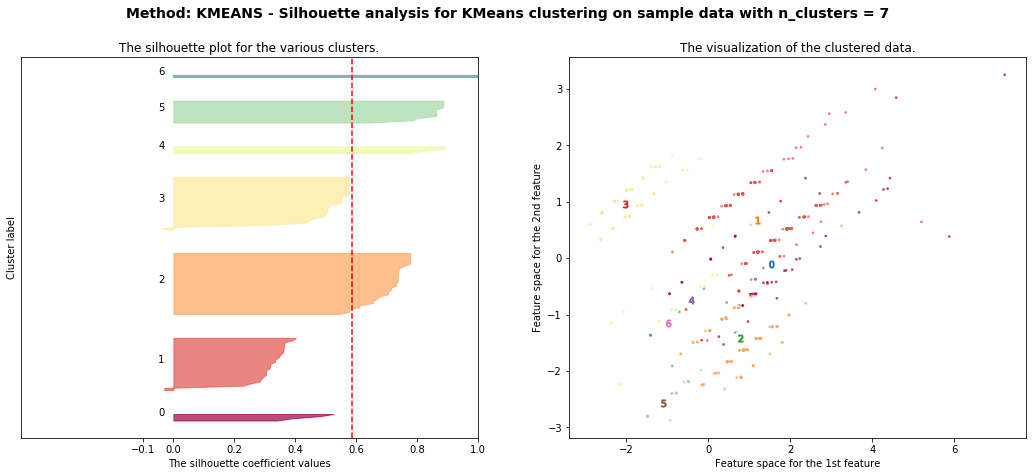

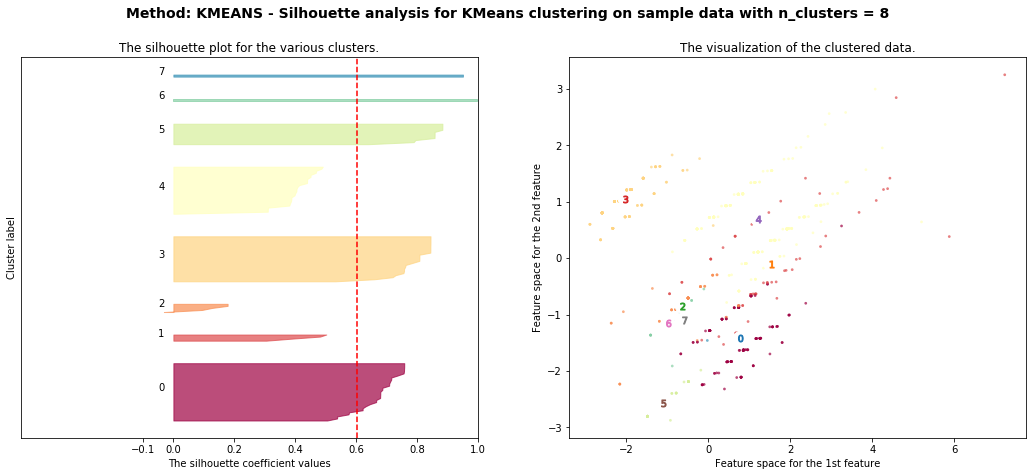

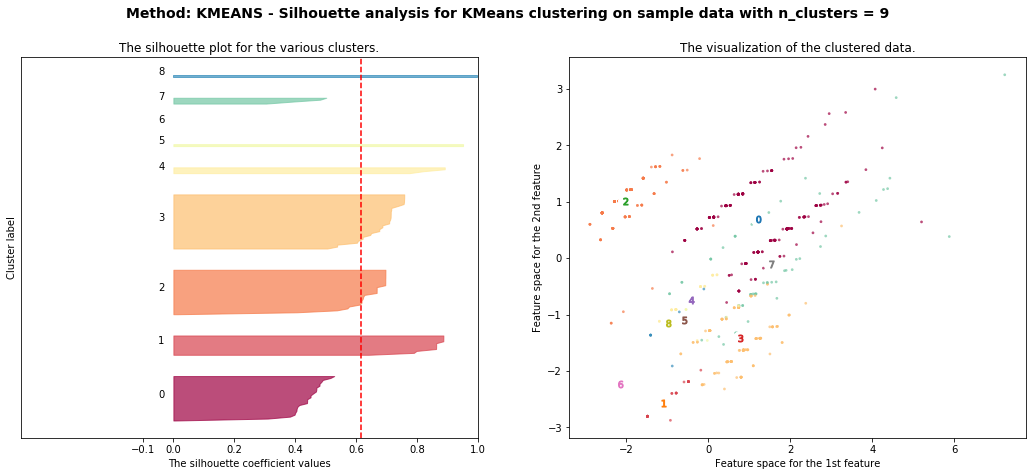

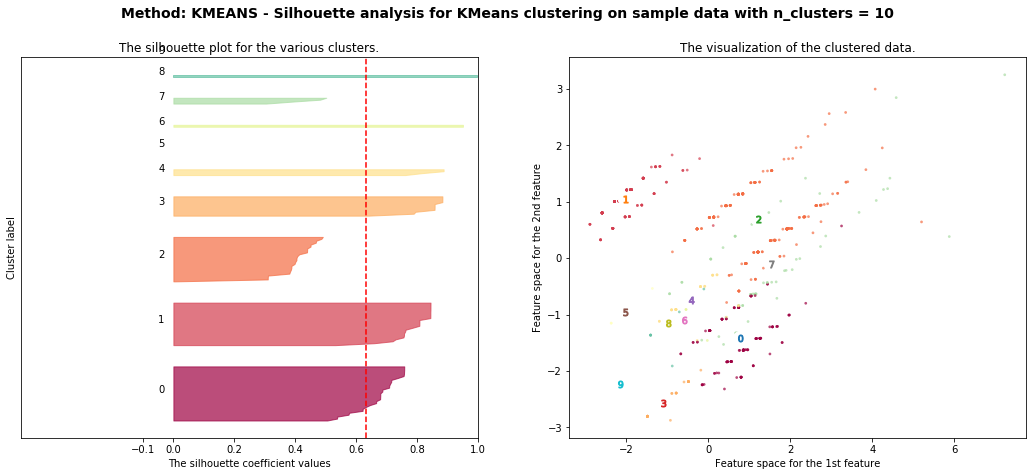

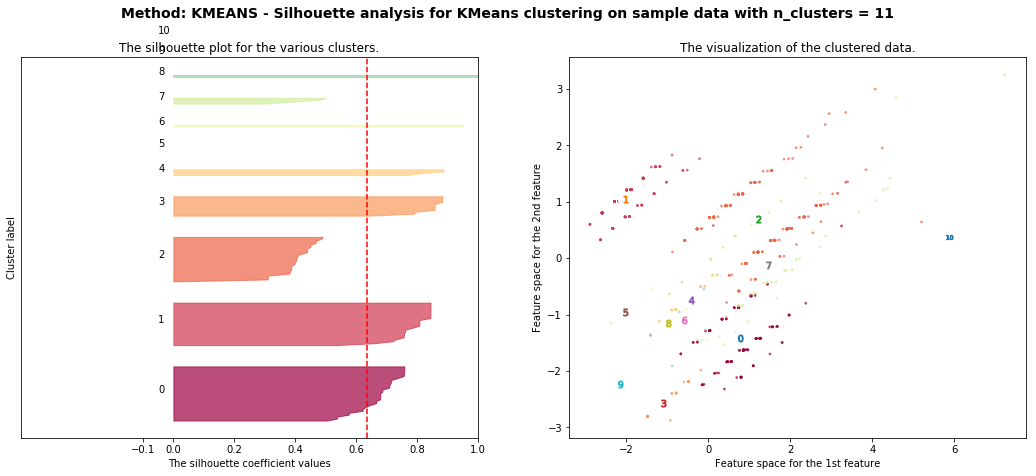

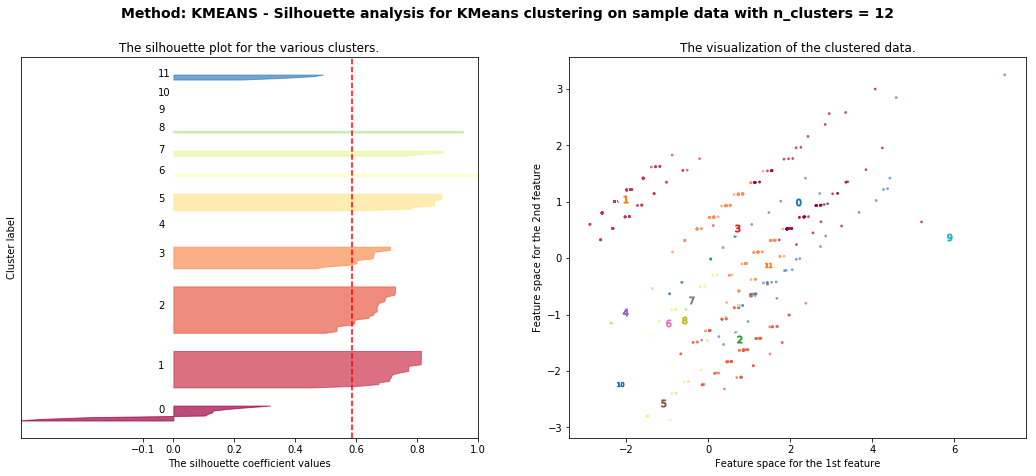

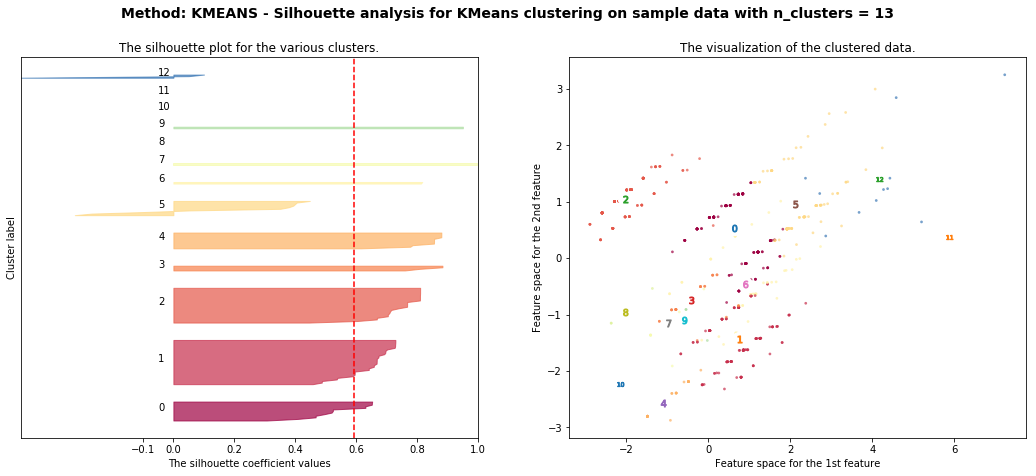

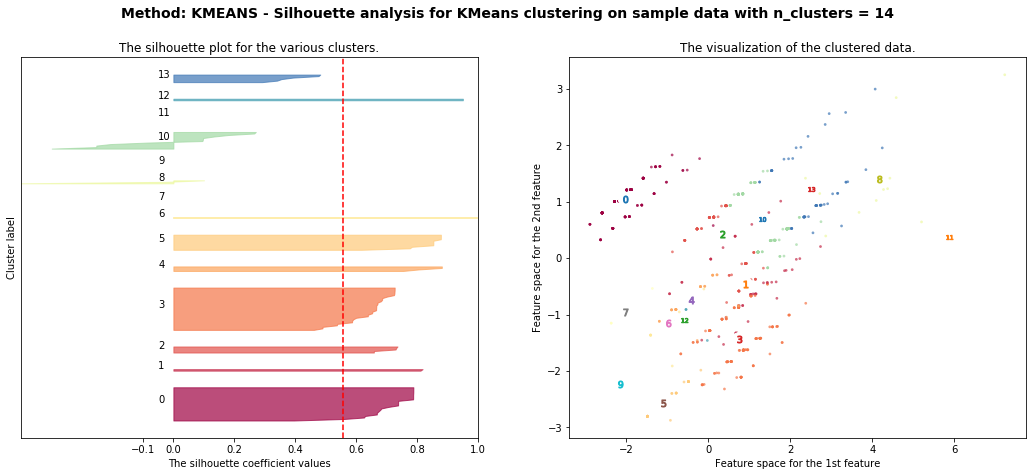

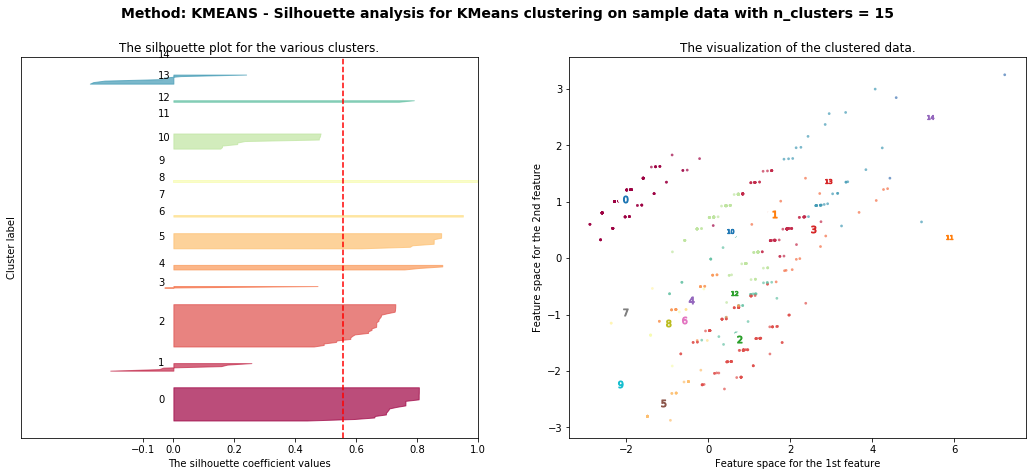

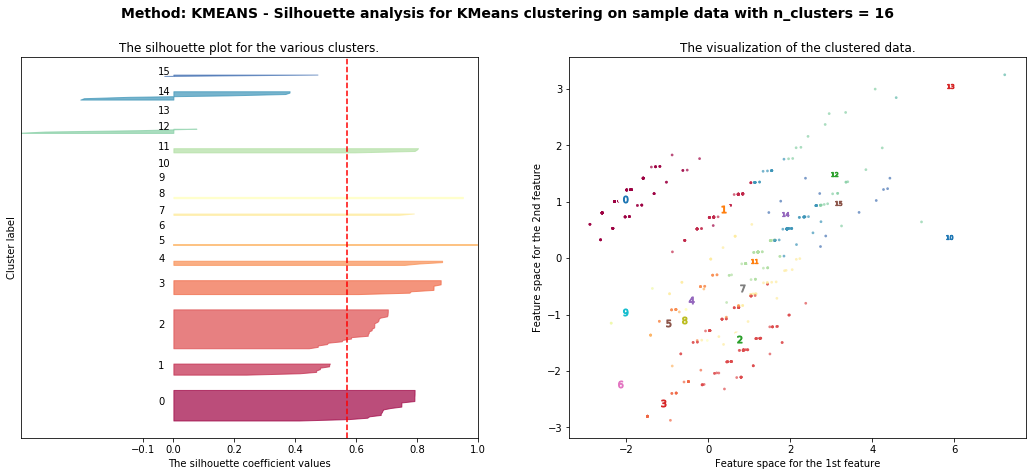

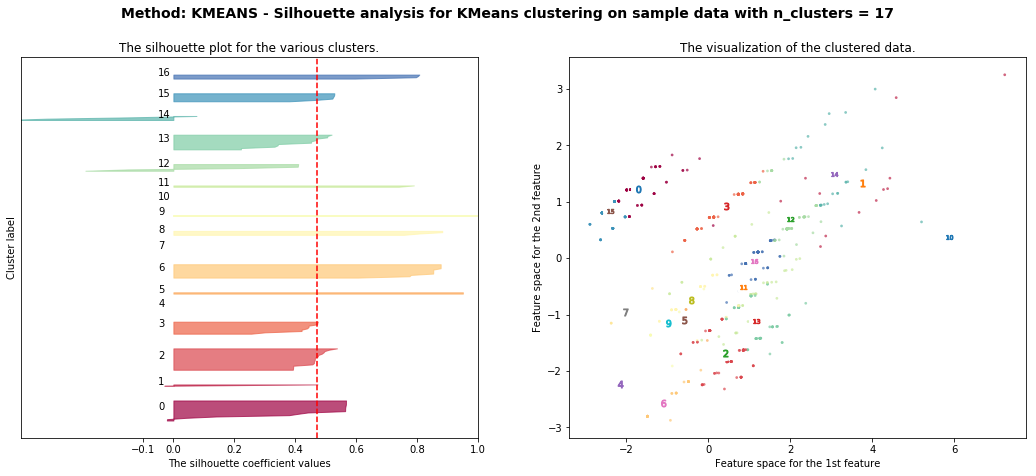

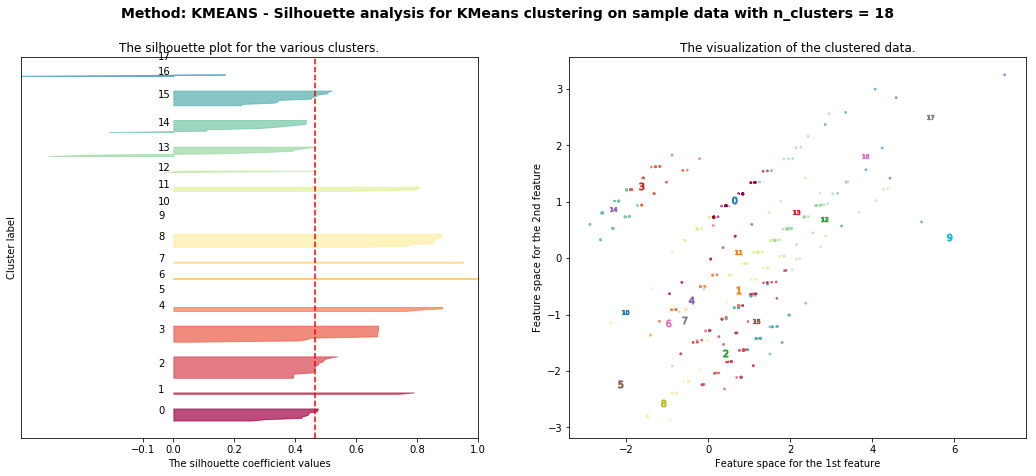

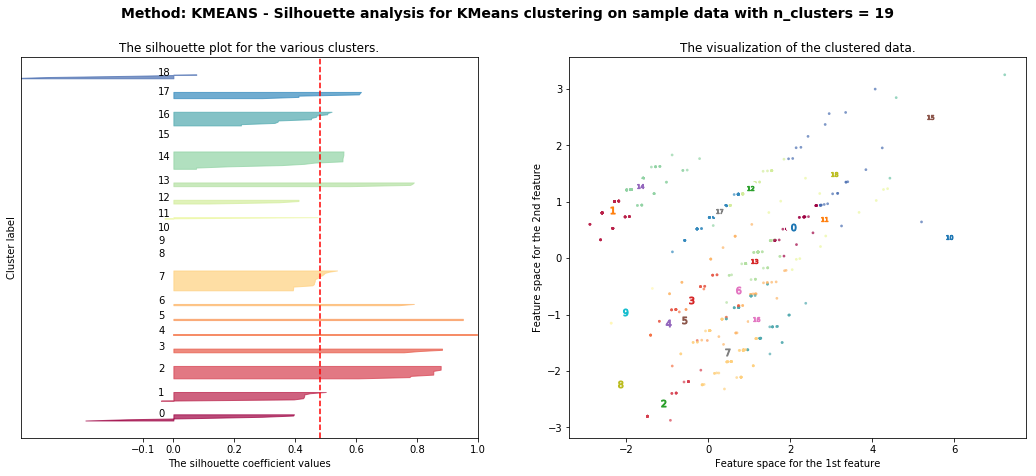

In [228]:
n_size = 100
df_res = []
for n_clusters in range(2,20):
    df_x1, cluster_labels1, plt1, silhouette_avg1 = siloutte_analisys(
        n_size, n_clusters,X_pca,df_features,min_samples=5,algo='KMEANS')
    df_res = df_res + [df_x1]
    print(silhouette_avg1)